# Backpropagation and Introduction to PyTorch

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 15 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*

## Introduction

In Chapter 15, we explored the theoretical foundations of neural networks, establishing them as universal function approximators capable of modeling complex relationships in astronomical data. We examined how these powerful models extend familiar concepts from linear and logistic regression to create flexible architectures that can learn hierarchical representations of data. Now we turn our attention to the practical machinery that makes neural network training possible: the backpropagation algorithm and its modern implementation in automatic differentiation frameworks.

The transition from theory to practice in neural networks presents a fundamental computational challenge. While the mathematics of gradient-based optimization remains conceptually similar to what we encountered with simpler models, the sheer complexity of computing gradients through deeply nested functions would seem to make neural network training computationally intractable. A neural network with millions of parameters requires us to compute how the loss function changes with respect to each of these parameters—a calculation that, if approached naively, would be prohibitively expensive.

This computational barrier was overcome by the backpropagation algorithm, which leverages the compositional structure of neural networks to compute gradients efficiently. By systematically applying the chain rule and reusing intermediate calculations, backpropagation transforms what could be an exponentially complex computation into one that scales linearly with the number of parameters. This algorithmic breakthrough, combined with modern automatic differentiation frameworks, has made it possible to train networks of unprecedented size and complexity.

PyTorch, the framework we'll explore in this tutorial, exemplifies how these theoretical advances have been translated into practical tools. At its core, PyTorch is an automatic differentiation engine that tracks operations on tensors and constructs computational graphs dynamically. This allows researchers to define complex models using familiar Python syntax while the framework handles the intricate bookkeeping required for gradient computation. The result is a powerful system that makes experimenting with neural architectures as straightforward as writing the forward pass of the computation.

The importance of understanding both backpropagation and its implementation cannot be overstated. While modern frameworks abstract away many details, a solid grasp of the underlying principles enables more effective debugging, better architectural choices, and deeper insights into model behavior. This tutorial bridges the gap between the mathematical exposition in the textbook and practical implementation, providing hands-on experience with the tools that have revolutionized not just astronomy, but scientific computing more broadly.



## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Proficiency with NumPy arrays, matplotlib visualization, and object-oriented programming concepts
- **Neural Network Theory**: Understanding of the material from Chapter 15, including forward propagation, activation functions, and loss functions
- **Optimization Concepts**: Knowledge of gradient descent and stochastic gradient descent from earlier chapters
- **Linear Algebra**: Comfort with matrix multiplication, derivatives, and the chain rule from multivariable calculus

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Automatic Differentiation**: Understanding how modern frameworks compute gradients efficiently through computational graphs
- **PyTorch Fundamentals**: Working with tensors, automatic differentiation, and GPU acceleration for scientific computing
- **Backpropagation Implementation**: Building intuition for how gradients flow through neural networks by implementing key components from scratch
- **Optimization in Practice**: Applying various optimization algorithms and understanding their convergence properties
- **Framework Proficiency**: Leveraging PyTorch's capabilities for both simple and complex models, preparing you for advanced architectures



## Understanding Backpropagation Through Implementation

Before leveraging modern automatic differentiation frameworks, let's build our intuition by implementing backpropagation from scratch using only NumPy. This hands-on approach will demystify the algorithm that revolutionized neural network training and provide deeper insight into how gradients flow through complex computational graphs.

The textbook established that neural networks are trained through gradient descent, where we iteratively update parameters in the direction that reduces the loss. The computational challenge lies in efficiently calculating gradients for potentially millions of parameters connected through complex, nested functions. Backpropagation solves this through a two-phase approach: a forward pass that computes and stores intermediate values, followed by a backward pass that efficiently propagates gradients using the chain rule.

To make these concepts concrete, we'll build a simple neural network from the ground up. We'll start with individual components—layers, activation functions, and loss functions—each capable of both forward computation and backward gradient propagation. This modular approach reveals the structure of backpropagation while maintaining complete transparency into the underlying mathematics.

Our implementation will follow the computational graph paradigm discussed in the textbook. Each component will:
1. Perform forward computation and cache necessary values
2. Implement backward computation using cached values and the chain rule
3. Update parameters (if any) using computed gradients

This structure directly reflects the mathematical framework where gradients flow backward through the computational graph, with each node contributing its local gradient to the overall computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Configure plotting parameters matching the textbook style
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

# Define colors for consistent plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

%matplotlib inline

### Building the Fully Connected Layer

Let's begin by implementing the fundamental building block of neural networks: the fully connected (or linear) layer. This layer performs the operation $\mathbf{y} = \mathbf{W} \cdot \mathbf{x} + \mathbf{b}$, where $\mathbf{W}$ is the weight matrix and $\mathbf{b}$ is the bias vector. Understanding how gradients flow through this operation is crucial for grasping backpropagation.

The fully connected layer must handle three key tasks:
1. **Forward pass**: Compute the linear transformation and store the input for later use
2. **Backward pass**: Calculate gradients with respect to weights, biases, and inputs
3. **Parameter update**: Adjust weights and biases using the computed gradients

In [2]:
class FullyConnectedLayer:
    """
    Implements a fully connected (linear) layer: y = Wx + b
    
    This layer demonstrates the core concepts of backpropagation:
    - Caching inputs during forward pass for gradient computation
    - Computing gradients using the chain rule during backward pass
    - Updating parameters using gradient descent
    """
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize parameters
        self.weight = np.zeros((in_features, out_features))
        self.bias = np.zeros((out_features, 1))
        
        # Storage for gradients
        self.g_weight = np.zeros((in_features, out_features))
        self.g_bias = np.zeros((out_features, 1))
        
        # Cache for input (needed for backward pass)
        self.input = None
    
    def init_weights(self):
        """Initialize weights using Xavier initialization for better convergence"""
        scale = np.sqrt(2.0 / self.in_features)
        self.weight = np.random.randn(self.in_features, self.out_features) * scale
        self.bias = np.zeros((self.out_features, 1))
    
    def forward_pass(self, X):
        """
        Forward propagation: y = Wx + b
        
        Parameters:
        -----------
        X : array of shape (batch_size, in_features)
            Input data
            
        Returns:
        --------
        out : array of shape (batch_size, out_features)
            Output of linear transformation
        """
        self.input = X  # Cache input for backward pass
        out = np.dot(X, self.weight) + self.bias.T
        return out
    
    def backward_pass(self, g_next_layer):
        """
        Backward propagation through the layer
        
        Parameters:
        -----------
        g_next_layer : array of shape (batch_size, out_features)
            Gradient flowing from the next layer
            
        Returns:
        --------
        g_last_layer : array of shape (batch_size, in_features)
            Gradient to propagate to previous layer
        """
        # Gradient w.r.t weights: dL/dW = X^T @ dL/dy
        self.g_weight = np.dot(self.input.T, g_next_layer)
        
        # Gradient w.r.t bias: dL/db = sum(dL/dy) over batch
        self.g_bias = np.sum(g_next_layer, axis=0, keepdims=True)
        
        # Gradient w.r.t input: dL/dX = dL/dy @ W^T
        g_last_layer = np.dot(g_next_layer, self.weight.T)
        
        return g_last_layer
    
    def update(self, learning_rate):
        """Update parameters using gradient descent"""
        self.weight -= learning_rate * self.g_weight
        self.bias -= learning_rate * self.g_bias.T

### Understanding the Fully Connected Layer Operations

The implementation above encapsulates the essential mechanics of backpropagation. Let's examine each operation to understand how gradients flow through the layer.

**Forward Pass**: The computation $\mathbf{y} = \mathbf{W}\mathbf{x} + \mathbf{b}$ is straightforward, but crucially, we cache the input $\mathbf{x}$. This isn't just for convenience—it's essential for efficient gradient computation. As we saw in the textbook, gradients are always evaluated at specific points in parameter space. Without storing the input values from the forward pass, we would need to recompute them during backpropagation.

**Backward Pass**: This is where the chain rule comes into play. Given the gradient from the next layer $\frac{\partial L}{\partial \mathbf{y}}$, we need to compute three quantities:

1. **Gradient w.r.t. weights**: $\frac{\partial L}{\partial \mathbf{W}} = \frac{\partial L}{\partial \mathbf{y}} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{W}} = \mathbf{x}^T \cdot \frac{\partial L}{\partial \mathbf{y}}$
   
2. **Gradient w.r.t. bias**: $\frac{\partial L}{\partial \mathbf{b}} = \frac{\partial L}{\partial \mathbf{y}} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{b}} = \frac{\partial L}{\partial \mathbf{y}}$ (summed over batch)
   
3. **Gradient w.r.t. input**: $\frac{\partial L}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{y}} \cdot \frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{y}} \cdot \mathbf{W}^T$

The gradient with respect to the input is particularly important—it's what we pass to the previous layer, enabling the backward flow of gradients through the entire network.



### Implementing the Sigmoid Activation Function

Next, we'll implement the sigmoid activation function $\sigma(z) = \frac{1}{1 + e^{-z}}$. Activation functions introduce nonlinearity into neural networks, enabling them to learn complex patterns. The sigmoid function is particularly instructive because its derivative has a simple form that depends only on the function's output.

In [3]:
class Sigmoid:
    """
    Implements the sigmoid activation function: σ(z) = 1/(1 + exp(-z))
    
    The sigmoid function demonstrates how:
    - Its derivative has a simple form: σ'(z) = σ(z)(1 - σ(z))
    - Gradients are modified by activation functions
    - It connects to our earlier discussion of logistic regression
    """
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward_pass(self, X):
        """
        Forward propagation through sigmoid activation
        
        Parameters:
        -----------
        X : array
            Input to the activation function
            
        Returns:
        --------
        output : array
            Sigmoid activation applied element-wise
        """
        self.input = X
        self.output = 1 / (1 + np.exp(-X))
        return self.output
    
    def backward_pass(self, g_next_layer):
        """
        Backward propagation through sigmoid activation
        
        The gradient is scaled by the local derivative:
        dL/dz = dL/dσ * dσ/dz = dL/dσ * σ(z)(1 - σ(z))
        """
        # Sigmoid derivative: σ'(z) = σ(z)(1 - σ(z))
        sigmoid_derivative = self.output * (1 - self.output)
        
        # Apply chain rule: multiply incoming gradient by local derivative
        g_last_layer = g_next_layer * sigmoid_derivative
        
        return g_last_layer
    
    def update(self, learning_rate):
        """Activation functions have no parameters to update"""
        pass

### The Sigmoid Derivative

The sigmoid implementation demonstrates an important computational property that makes it efficient for backpropagation. We compute the derivative as $\sigma'(z) = \sigma(z)(1 - \sigma(z))$—it depends only on the sigmoid's output, not its input. This means we can calculate the derivative using the cached output from the forward pass without referring back to the original input values.

During the backward pass, the activation function acts as a gate that modulates the gradient flow. For sigmoid, gradients are largest when the output is near 0.5 (where $\sigma(z)(1-\sigma(z))$ is maximized at 0.25) and smallest when the output saturates near 0 or 1. This behavior connects directly to the vanishing gradient problem discussed in the textbook—when sigmoid outputs saturate, gradients become very small, slowing or stopping learning in earlier layers.



### Implementing the Mean Squared Error Loss

To complete our building blocks, we need a loss function. We'll implement Mean Squared Error (MSE), which, as discussed in the textbook, emerges naturally from maximum likelihood estimation under the assumption of Gaussian noise.

In [4]:
class MSELoss:
    """
    Implements Mean Squared Error loss: L = (1/N) Σ(y_pred - y_true)²
    
    This loss function:
    - Measures the average squared difference between predictions and targets
    - Arises from maximum likelihood estimation with Gaussian noise assumption
    - Provides the starting gradient for backpropagation
    """
    def __init__(self):
        self.y_pred = None
        self.y_true = None
        self.batch_size = None
    
    def forward_pass(self, y_pred, y_true):
        """
        Compute the MSE loss
        
        Parameters:
        -----------
        y_pred : array of shape (batch_size, output_dim)
            Model predictions
        y_true : array of shape (batch_size, output_dim)
            Ground truth values
            
        Returns:
        --------
        loss : float
            Mean squared error averaged over batch
        """
        # Ensure y_true has correct shape
        if len(y_true.shape) == 1:
            y_true = y_true[:, np.newaxis]
        
        self.y_pred = y_pred
        self.y_true = y_true
        self.batch_size = y_pred.shape[0]
        
        # Compute squared differences
        squared_errors = (y_pred - y_true) ** 2
        
        # Return mean over all elements
        return np.mean(squared_errors)
    
    def backward_pass(self, g_next_layer=1):
        """
        Compute gradient of MSE loss
        
        For MSE: dL/dy_pred = (2/N) * (y_pred - y_true)
        """
        # Gradient of MSE: dL/dy = 2(y_pred - y_true) / N
        g_last_layer = 2 * (self.y_pred - self.y_true) / self.batch_size * g_next_layer
        
        return g_last_layer
    
    def update(self, learning_rate):
        """Loss functions have no parameters to update"""
        pass

### Understanding the Loss Function's Role in Backpropagation

The MSE loss implementation highlights a crucial aspect of backpropagation: the loss function provides the initial gradient that flows backward through the network. When we call `backward_pass()` on the loss, we typically pass `g_next_layer=1` because the loss is a scalar function—its derivative with respect to itself is simply 1.

The gradient computation $\frac{\partial L}{\partial \mathbf{y}_{\text{pred}}} = \frac{2}{N}(\mathbf{y}_{\text{pred}} - \mathbf{y}_{\text{true}})$ follows directly from differentiating the MSE formula. The factor of $\frac{1}{N}$ ensures that our gradient magnitude doesn't scale with batch size, maintaining consistent learning dynamics regardless of whether we process 32 or 256 examples at once.



### Assembling a Complete Neural Network

With our building blocks in place, we can now construct a neural network that chains these components together. Our network will have a flexible architecture that can approximate a wide variety of functions.

In [5]:
class Network:
    """
    A neural network with configurable architecture
    
    Architecture: Input → FC → Sigmoid → FC → Output
    
    This implementation demonstrates:
    - How layers are composed in sequence
    - How forward pass flows through the network
    - How gradients propagate backward through all layers
    - How parameters are updated after backpropagation
    """
    def __init__(self, input_dim=1, hidden_dim=10, output_dim=1):
        self.layers = []
        
        # Build the network architecture
        # Layer 1: Fully connected (input_dim -> hidden_dim)
        fc1 = FullyConnectedLayer(input_dim, hidden_dim)
        fc1.init_weights()
        self.layers.append(fc1)
        
        # Activation: Sigmoid (only in hidden layer)
        sigmoid = Sigmoid()
        self.layers.append(sigmoid)
        
        # Layer 2: Fully connected (hidden_dim -> output_dim)
        fc2 = FullyConnectedLayer(hidden_dim, output_dim)
        fc2.init_weights()
        self.layers.append(fc2)
        
        # No activation on output layer for regression
    
    def forward_pass(self, X):
        """Forward propagation through the entire network"""
        output = X
        for layer in self.layers:
            output = layer.forward_pass(output)
        return output
    
    def backward_pass(self, grad):
        """Backward propagation through the entire network"""
        # Pass gradient backward through layers in reverse order
        for layer in reversed(self.layers):
            grad = layer.backward_pass(grad)
    
    def update(self, learning_rate):
        """Update all trainable parameters in the network"""
        for layer in self.layers:
            layer.update(learning_rate)

### Understanding the Network Architecture

Our network implements a standard architecture for regression tasks:

1. **Hidden layer with activation**: The first layer followed by sigmoid creates a nonlinear feature representation. With multiple hidden units, each can learn to detect different aspects of the input pattern.

2. **Linear output layer**: The second layer performs a linear combination of these features without constraining the output range. This allows the network to produce any real-valued output, essential for regression problems.

This design follows the universal approximation theorem discussed in the textbook—a network with sufficient hidden units and at least one nonlinear activation can approximate any continuous function to arbitrary accuracy.



### Training on Synthetic Data

Let's generate synthetic data and train our network to see backpropagation in action.

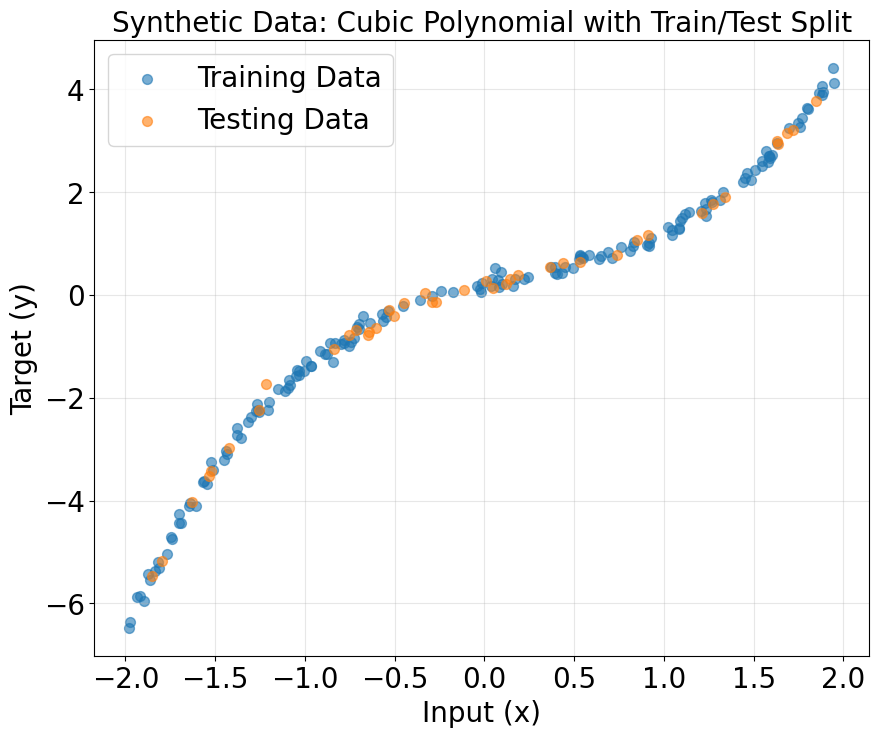

Training samples: 160
Testing samples: 40


In [6]:
# Generate synthetic data with train/test split
np.random.seed(42)

# Create data
n_samples = 200
X_all = np.random.uniform(-2, 2, (n_samples, 1))

# Generate target data: cubic polynomial with some noise
# y = 0.5x³ - 0.3x² + 0.8x + 0.2
coefficients = [0.5, -0.3, 0.8, 0.2]
y_all = (coefficients[0] * X_all**3 + 
         coefficients[1] * X_all**2 + 
         coefficients[2] * X_all + 
         coefficients[3])
y_all += 0.1 * np.random.randn(n_samples, 1)  # Add Gaussian noise

# Split into training and testing sets (80/20 split)
n_train = int(0.8 * n_samples)
indices = np.random.permutation(n_samples)
train_idx, test_idx = indices[:n_train], indices[n_train:]

X_train, X_test = X_all[train_idx], X_all[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

# Visualize the data split
plt.figure(figsize=(10, 8))
plt.scatter(X_train, y_train, alpha=0.6, s=50, color=colors[0], label='Training Data')
plt.scatter(X_test, y_test, alpha=0.6, s=50, color=colors[1], label='Testing Data')
plt.xlabel('Input (x)')
plt.ylabel('Target (y)')
plt.title('Synthetic Data: Cubic Polynomial with Train/Test Split')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

### Training with Validation Monitoring

Now we'll train our network while monitoring both training and testing performance. This allows us to detect overfitting and understand how well our network generalizes to unseen data.

In [7]:
# Initialize the network and loss function
network = Network(input_dim=1, hidden_dim=20, output_dim=1)
mse_loss = MSELoss()

# Training hyperparameters
learning_rate = 0.03
n_epochs = 100000

# Storage for tracking training progress
train_loss_history = []
test_loss_history = []

# Training loop
print("Training the network...")
for epoch in range(n_epochs):
    # Forward pass on training data
    y_pred_train = network.forward_pass(X_train)
    
    # Compute training loss
    train_loss = mse_loss.forward_pass(y_pred_train, y_train)
    train_loss_history.append(train_loss)
    
    # Backward pass - compute gradients
    grad = mse_loss.backward_pass()
    network.backward_pass(grad)
    
    # Update parameters
    network.update(learning_rate)
    
    # Evaluate on test set (no gradient computation needed)
    y_pred_test = network.forward_pass(X_test)
    test_loss = mse_loss.forward_pass(y_pred_test, y_test)
    test_loss_history.append(test_loss)
    
    # Print progress
    if epoch % 10000 == 0:
        print(f"Epoch {epoch:5d}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")

# Final losses
print(f"\nFinal train loss: {train_loss_history[-1]:.6f}")
print(f"Final test loss: {test_loss_history[-1]:.6f}")

Training the network...
Epoch     0: Train Loss = 10.233850, Test Loss = 5.633976
Epoch 10000: Train Loss = 0.045436, Test Loss = 0.040987
Epoch 20000: Train Loss = 0.022056, Test Loss = 0.017724
Epoch 30000: Train Loss = 0.016035, Test Loss = 0.012326
Epoch 40000: Train Loss = 0.014428, Test Loss = 0.011432
Epoch 50000: Train Loss = 0.013374, Test Loss = 0.010838
Epoch 60000: Train Loss = 0.012598, Test Loss = 0.010407
Epoch 70000: Train Loss = 0.012002, Test Loss = 0.010088
Epoch 80000: Train Loss = 0.011528, Test Loss = 0.009849
Epoch 90000: Train Loss = 0.011142, Test Loss = 0.009667

Final train loss: 0.010822
Final test loss: 0.009528


### Visualizing the Training Results

Let's examine how our network learned to approximate the cubic polynomial through training.

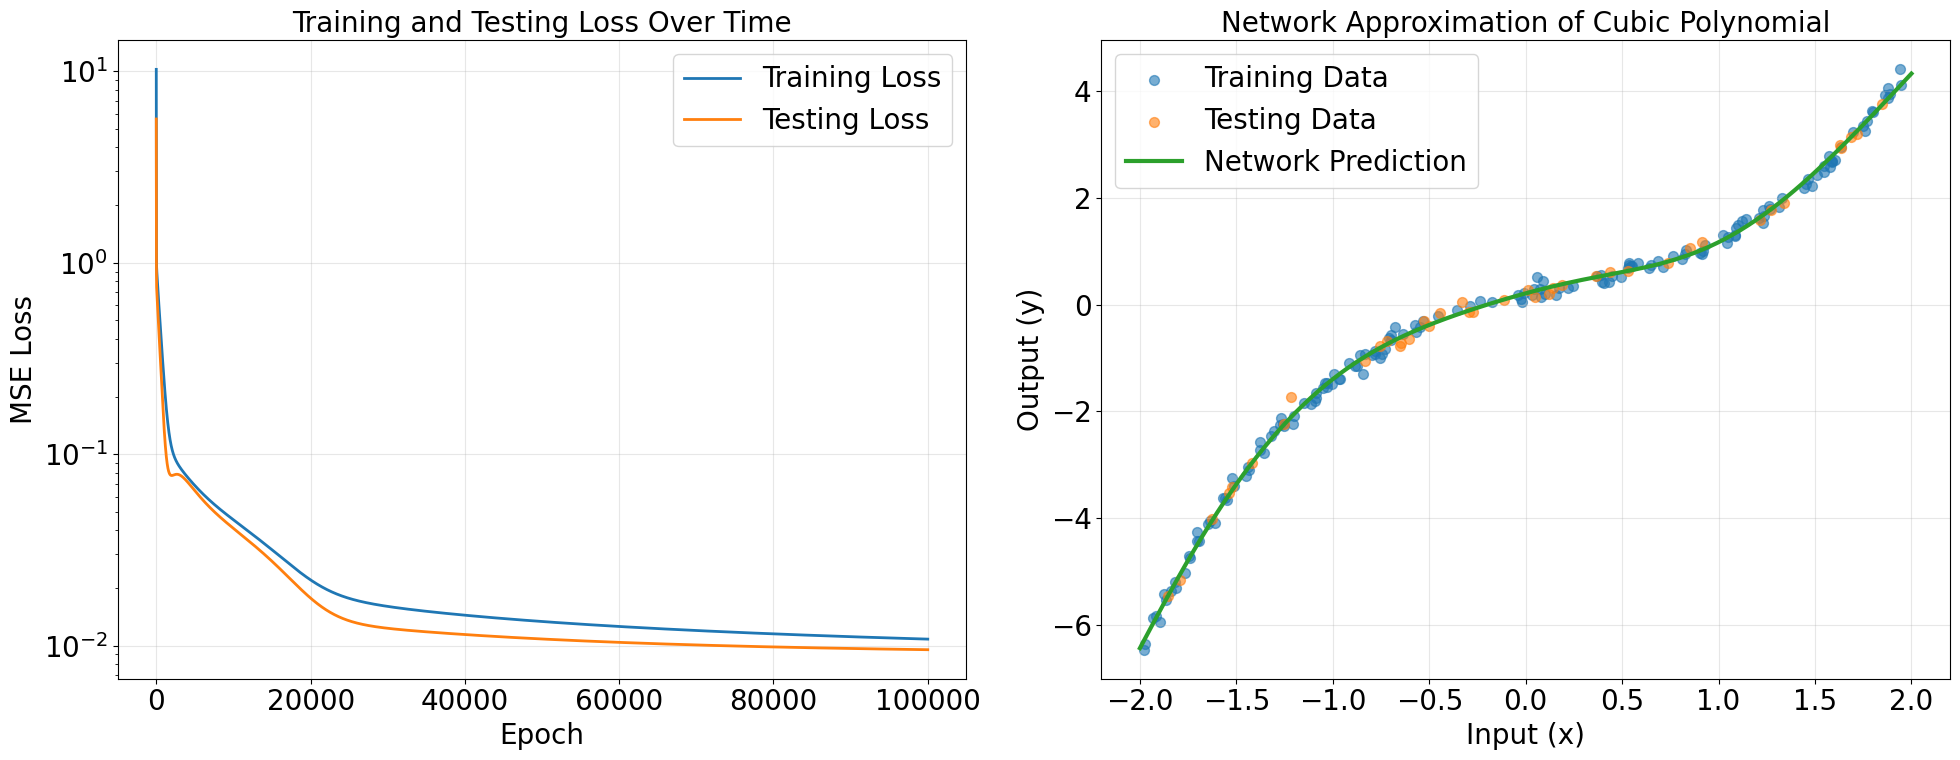

In [8]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Training and testing loss history
ax1.plot(train_loss_history, linewidth=2, color=colors[0], label='Training Loss')
ax1.plot(test_loss_history, linewidth=2, color=colors[1], label='Testing Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training and Testing Loss Over Time')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Final predictions vs true data
# Generate smooth predictions for visualization
X_plot = np.linspace(-2, 2, 200).reshape(-1, 1)
y_pred_plot = network.forward_pass(X_plot)

ax2.scatter(X_train, y_train, alpha=0.6, s=50, color=colors[0], label='Training Data')
ax2.scatter(X_test, y_test, alpha=0.6, s=50, color=colors[1], label='Testing Data')
ax2.plot(X_plot, y_pred_plot, linewidth=3, color=colors[2], label='Network Prediction')
ax2.set_xlabel('Input (x)')
ax2.set_ylabel('Output (y)')
ax2.set_title('Network Approximation of Cubic Polynomial')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Insights from Our Implementation

Our hand-built neural network successfully learned to approximate a cubic polynomial using only basic NumPy operations. Several key observations emerge from this implementation:

1. **Gradient Flow**: The backward pass efficiently propagates gradients from the loss function through each layer, with each component computing only its local derivatives. This modular design scales to arbitrarily deep networks.

2. **Cached Computations**: The forward pass stores intermediate values (inputs, outputs, activations) that are essential for gradient computation. Without this caching, we would need to recompute values during backpropagation, significantly increasing computational cost.

3. **Learning Dynamics**: The loss curves show characteristic neural network training behavior—rapid initial decrease followed by slower refinement. The similar training and testing losses indicate our network generalized well without overfitting.

4. **Architectural Choices**: With 20 hidden units and sigmoid activation, our network had sufficient capacity to model the cubic polynomial. The linear output layer was crucial for matching the full range of target values.

This implementation demonstrates that backpropagation, while mathematically intricate, follows a systematic pattern that can be implemented with basic array operations. However, manually implementing every layer type, activation function, and optimization algorithm would quickly become tedious for real research. This motivates the use of automatic differentiation frameworks that handle these details while preserving computational efficiency.



## PyTorch - Automatic Differentiation Made Simple

Having implemented backpropagation from scratch, we can now appreciate what PyTorch brings to the table. Our manual implementation required us to carefully track forward computations and implement backward passes for each component. PyTorch automates this entire process while maintaining the same mathematical rigor.

The key insight from our implementation was that each operation needs to store two pieces of information: the computed value and the ability to compute gradients. PyTorch tensors with `requires_grad=True` do exactly this—they form a "dual" representation that tracks both the data and the computational graph needed for differentiation.

In [9]:
# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Set random seed for reproducibility
torch.manual_seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# For this tutorial, we'll work on CPU to match our NumPy implementation
device = torch.device('cpu')

PyTorch version: 2.7.1
Using device: cpu


### PyTorch Tensors and Automatic Differentiation

PyTorch tensors are the fundamental data structure, similar to NumPy arrays but with automatic differentiation capabilities. When we set `requires_grad=True` on a tensor, PyTorch begins building a computational graph behind the scenes. This creates what we call a **dual representation**—each tensor simultaneously holds:

1. **The actual data values** (like a regular NumPy array)
2. **Gradient information** (stored in the `.grad` attribute after backpropagation)
3. **Graph connectivity** (references to the operations that created this tensor)
4. **Backward functions** (the local derivative computations, similar to our manual `backward()` methods)

Let's start with a simple example that parallels our earlier discussion:

In [10]:
# Simple automatic differentiation example
# Let's compute the gradient of f(x) = x^2 at x = 3

# Create a tensor with gradient tracking enabled
x = torch.tensor([3.0], requires_grad=True)
print(f"x = {x}")
print(f"requires_grad: {x.requires_grad}")

# Perform computation
y = x**2
print(f"\ny = x^2 = {y}")

# Compute gradient using backpropagation
y.backward()
print(f"\ndy/dx = {x.grad}")
print(f"Expected: 2*x = {2*x.item()}")

x = tensor([3.], requires_grad=True)
requires_grad: True

y = x^2 = tensor([9.], grad_fn=<PowBackward0>)

dy/dx = tensor([6.])
Expected: 2*x = 6.0


### Understanding PyTorch's Implementation

In just a few lines, PyTorch performed what took us significant code to implement manually. When we computed `y = x**2`, PyTorch:
1. Performed the forward computation (squaring x)
2. Built a computational graph tracking this operation
3. Stored information needed for the backward pass

The `backward()` call then traversed this graph in reverse, computing gradients automatically. Let's examine a more complex example that mirrors our neural network computation:

In [11]:
# More complex example: linear transformation followed by sigmoid
# This mirrors our manual implementation

# Input data
x = torch.tensor([[2.0]], requires_grad=True)

# Parameters (similar to our FullyConnectedLayer)
W = torch.tensor([[1.5]], requires_grad=True)
b = torch.tensor([[-1.0]], requires_grad=True)

# Forward pass: z = Wx + b, y = sigmoid(z)
z = torch.matmul(W, x) + b
y = torch.sigmoid(z)

# Define a simple loss (squared difference from target)
target = torch.tensor([[0.8]])
loss = (y - target)**2

print(f"Forward pass:")
print(f"  x = {x.item():.3f}")
print(f"  z = Wx + b = {z.item():.3f}")
print(f"  y = sigmoid(z) = {y.item():.3f}")
print(f"  loss = (y - target)² = {loss.item():.6f}")

# Backward pass
loss.backward()

print(f"\nGradients after backward pass:")
print(f"  dL/dW = {W.grad.item():.6f}")
print(f"  dL/db = {b.grad.item():.6f}")
print(f"  dL/dx = {x.grad.item():.6f}")

Forward pass:
  x = 2.000
  z = Wx + b = 2.000
  y = sigmoid(z) = 0.881
  loss = (y - target)² = 0.006528

Gradients after backward pass:
  dL/dW = 0.033933
  dL/db = 0.016966
  dL/dx = 0.025450


### Inspecting the Computational Graph

PyTorch builds its computational graph dynamically. We can inspect this graph to understand how operations are connected:

In [12]:
# Inspect the computational graph structure
print("Computational graph structure:")
print(f"loss.grad_fn: {loss.grad_fn}")
print(f"  └─ {loss.grad_fn.next_functions[0][0]}")  # Subtraction
print(f"      └─ {loss.grad_fn.next_functions[0][0].next_functions[0][0]}")  # Sigmoid
print(f"          └─ {loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0]}")  # Add

# Each grad_fn represents an operation in the backward pass
# This is exactly the chain we implemented manually:
# loss -> (y - target) -> sigmoid -> (Wx + b)

# We can also visualize which tensors require gradients
print("\nTensors requiring gradients:")
for name, tensor in [('x', x), ('W', W), ('b', b), ('y', y), ('loss', loss)]:
    print(f"  {name}: requires_grad={tensor.requires_grad}, "
          f"is_leaf={tensor.is_leaf}, "
          f"grad_fn={tensor.grad_fn}")

Computational graph structure:
loss.grad_fn: <PowBackward0 object at 0x13a834e50>
  └─ <SubBackward0 object at 0x13a40a560>
      └─ <SigmoidBackward0 object at 0x13a834e50>
          └─ <AddBackward0 object at 0x13a40a560>

Tensors requiring gradients:
  x: requires_grad=True, is_leaf=True, grad_fn=None
  W: requires_grad=True, is_leaf=True, grad_fn=None
  b: requires_grad=True, is_leaf=True, grad_fn=None
  y: requires_grad=True, is_leaf=False, grad_fn=<SigmoidBackward0 object at 0x13a40a560>
  loss: requires_grad=True, is_leaf=False, grad_fn=<PowBackward0 object at 0x13a40a560>


### Understanding PyTorch's Computational Graph

The output reveals how PyTorch automatically constructs the same computational graph we drew manually. Each `grad_fn` object represents a backward operation:

- **`PowBackward0`**: The backward pass for squaring (from our loss computation)
- **`SubBackward0`**: The backward pass for subtraction (y - target)
- **`SigmoidBackward0`**: The backward pass for the sigmoid function
- **`AddBackward0`**: The backward pass for addition (Wx + b)

The distinction between **leaf** and **non-leaf** tensors is important:
- **Leaf tensors** (x, W, b): Created by the user with `requires_grad=True`. These accumulate gradients.
- **Non-leaf tensors** (y, loss): Results of operations. These have `grad_fn` showing how they were computed.

This automatic graph construction is what makes PyTorch powerful—we write the forward pass naturally, and PyTorch handles all the backward pass complexity we implemented manually.

### Recreating Our Neural Network in PyTorch

Now let's implement the same neural network architecture we built manually, but using PyTorch's built-in modules:

In [13]:
# Define the same network architecture using PyTorch modules
class PyTorchNetwork(nn.Module):
    """
    PyTorch implementation of our manual network
    Architecture: Input → FC(1→hidden_dim) → Sigmoid → FC(hidden_dim→1) → Output
    """
    def __init__(self, input_dim=1, hidden_dim=20, output_dim=1):
        super(PyTorchNetwork, self).__init__()
        
        # Define layers - PyTorch handles all the parameter initialization
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        """
        Forward pass - PyTorch automatically builds the computational graph
        """
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        return x

# Create the network
pytorch_net = PyTorchNetwork(input_dim=1, hidden_dim=20, output_dim=1)

# Count parameters
total_params = sum(p.numel() for p in pytorch_net.parameters())
print(f"Network architecture:")
print(pytorch_net)
print(f"\nTotal parameters: {total_params}")

Network architecture:
PyTorchNetwork(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

Total parameters: 61


### Preparing Data for PyTorch

Let's prepare the same cubic polynomial dataset for PyTorch:

In [14]:
# Convert our NumPy data to PyTorch tensors
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()

print(f"Data shapes:")
print(f"  X_train: {X_train_torch.shape}, dtype: {X_train_torch.dtype}")
print(f"  y_train: {y_train_torch.shape}, dtype: {y_train_torch.dtype}")
print(f"  X_test: {X_test_torch.shape}, dtype: {X_test_torch.dtype}")
print(f"  y_test: {y_test_torch.shape}, dtype: {y_test_torch.dtype}")

Data shapes:
  X_train: torch.Size([160, 1]), dtype: torch.float32
  y_train: torch.Size([160, 1]), dtype: torch.float32
  X_test: torch.Size([40, 1]), dtype: torch.float32
  y_test: torch.Size([40, 1]), dtype: torch.float32


### Training with PyTorch

Now we'll train our PyTorch network. Notice how PyTorch handles all the complexity we implemented manually:

In [15]:
# Initialize the network
pytorch_net = PyTorchNetwork(input_dim=1, hidden_dim=20, output_dim=1)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Same as our MSELoss implementation
optimizer = optim.SGD(pytorch_net.parameters(), lr=0.03)  # Handles parameter updates

# Training parameters
n_epochs = 100000

# Storage for tracking progress
pytorch_train_loss = []
pytorch_test_loss = []

# Training loop
print("Training the PyTorch network...")
for epoch in range(n_epochs):
    # Forward pass
    y_pred = pytorch_net(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    
    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update parameters
    
    # Track training loss
    pytorch_train_loss.append(loss.item())
    
    # Evaluate on test set
    with torch.no_grad():  # Disable gradient computation for evaluation
        y_pred_test = pytorch_net(X_test_torch)
        test_loss = criterion(y_pred_test, y_test_torch)
        pytorch_test_loss.append(test_loss.item())
    
    # Print progress
    if epoch % 10000 == 0:
        print(f"Epoch {epoch:5d}: Train Loss = {loss.item():.6f}, Test Loss = {test_loss.item():.6f}")

print(f"\nFinal train loss: {pytorch_train_loss[-1]:.6f}")
print(f"Final test loss: {pytorch_test_loss[-1]:.6f}")

Training the PyTorch network...
Epoch     0: Train Loss = 5.736119, Test Loss = 3.991769
Epoch 10000: Train Loss = 0.037515, Test Loss = 0.026085
Epoch 20000: Train Loss = 0.013375, Test Loss = 0.010706
Epoch 30000: Train Loss = 0.010206, Test Loss = 0.009299
Epoch 40000: Train Loss = 0.009404, Test Loss = 0.008975
Epoch 50000: Train Loss = 0.009175, Test Loss = 0.008941
Epoch 60000: Train Loss = 0.009097, Test Loss = 0.008980
Epoch 70000: Train Loss = 0.009059, Test Loss = 0.009036
Epoch 80000: Train Loss = 0.009035, Test Loss = 0.009090
Epoch 90000: Train Loss = 0.009018, Test Loss = 0.009139

Final train loss: 0.009004
Final test loss: 0.009182


### Visualizing PyTorch Training Results

Let's examine the training results from our PyTorch implementation:

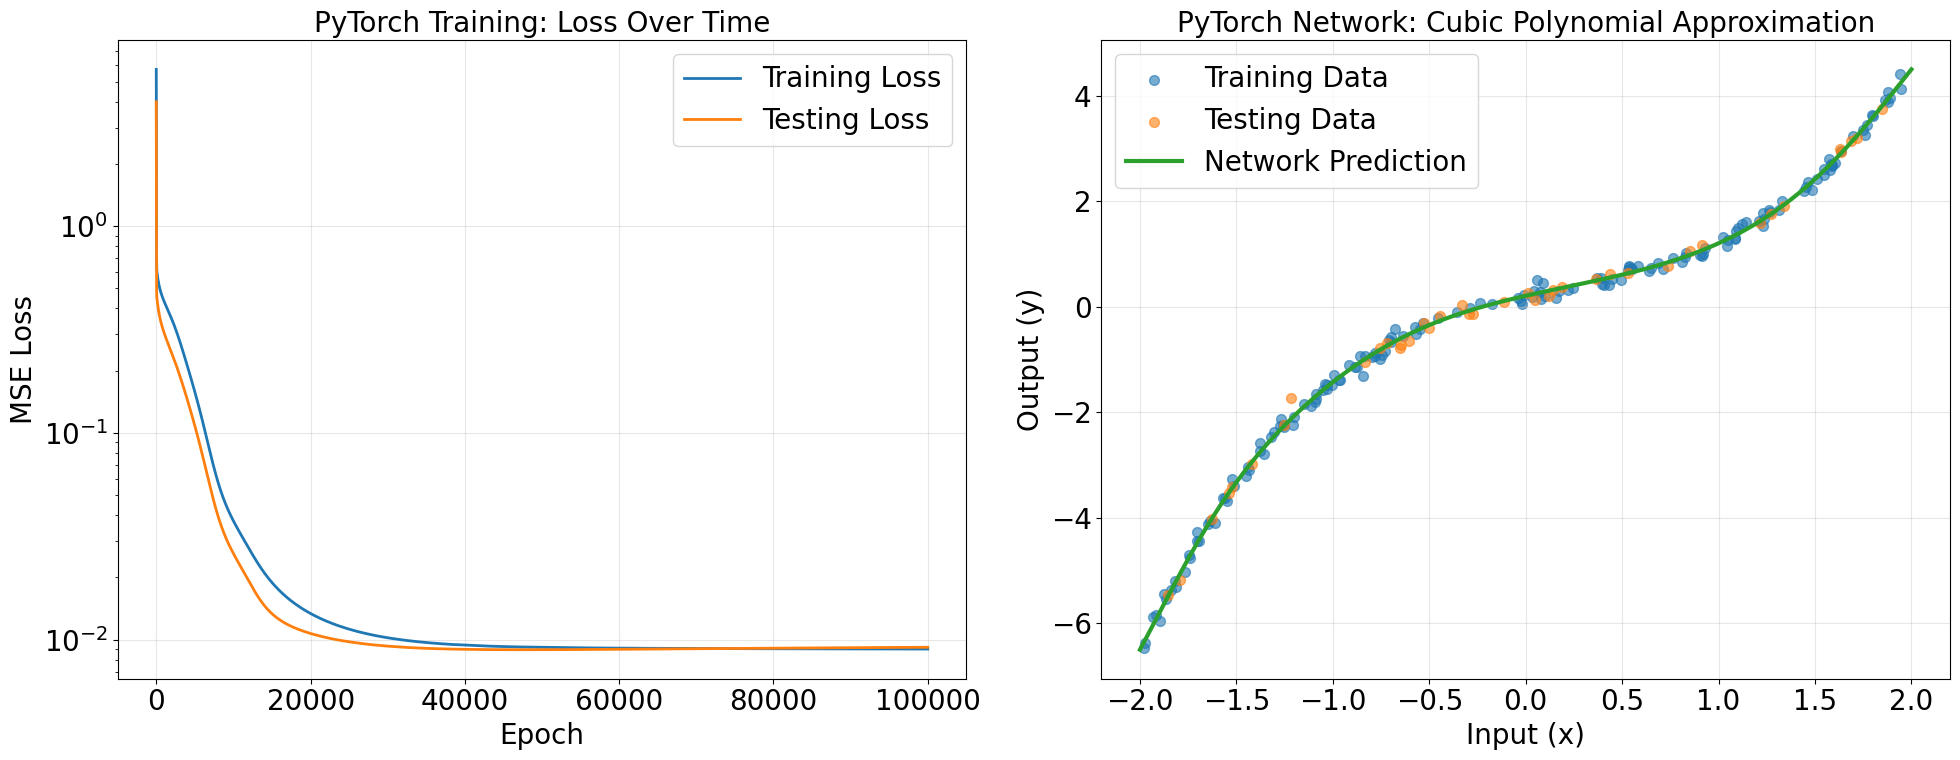

In [16]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Training and testing loss history
ax1.plot(pytorch_train_loss, linewidth=2, color=colors[0], label='Training Loss')
ax1.plot(pytorch_test_loss, linewidth=2, color=colors[1], label='Testing Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('PyTorch Training: Loss Over Time')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Final predictions vs true data
# Generate smooth predictions for visualization
X_plot_torch = torch.linspace(-2, 2, 200).view(-1, 1)
with torch.no_grad():
    y_pred_plot = pytorch_net(X_plot_torch).numpy()

ax2.scatter(X_train, y_train, alpha=0.6, s=50, color=colors[0], label='Training Data')
ax2.scatter(X_test, y_test, alpha=0.6, s=50, color=colors[1], label='Testing Data')
ax2.plot(X_plot_torch.numpy(), y_pred_plot, linewidth=3, color=colors[2], label='Network Prediction')
ax2.set_xlabel('Input (x)')
ax2.set_ylabel('Output (y)')
ax2.set_title('PyTorch Network: Cubic Polynomial Approximation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Key Advantages of PyTorch

The PyTorch implementation demonstrates several important advantages over manual implementation:

1. **Automatic Differentiation**: PyTorch automatically constructs the computational graph and computes gradients. What required careful implementation of forward and backward methods for each component is now handled automatically.

2. **Optimized Operations**: PyTorch's operations are implemented in optimized C++ code, making them significantly faster than our NumPy implementation, especially for larger networks.

3. **Memory Efficiency**: PyTorch manages memory for intermediate values automatically, allocating and freeing memory as needed during forward and backward passes.

4. **Built-in Components**: Common layers (Linear, Sigmoid), loss functions (MSELoss), and optimizers (SGD, Adam) are provided with robust, tested implementations.

5. **Device Abstraction**: The same code can run on CPU or GPU with minimal changes, enabling massive speedups for larger models.

The `optimizer.zero_grad()` call deserves special attention. PyTorch accumulates gradients by default rather than overwriting them—a design choice that enables gradient accumulation over multiple mini-batches (useful when full batches don't fit in memory) and simplifies multi-task learning where multiple losses contribute to the same parameters. Our manual implementation overwrote gradients each time, which was simpler but less flexible.



### Comparing Different Optimizers

While we used basic SGD in our manual implementation, PyTorch provides several advanced optimizers. Let's compare two key algorithms discussed in the textbook:

**SGD (Stochastic Gradient Descent)**: The basic algorithm we implemented manually. Updates parameters directly using the gradient scaled by the learning rate: $\mathbf{w} \leftarrow \mathbf{w} - \eta \nabla L$

**Adam (Adaptive Moment Estimation)**: As discussed in the textbook, Adam maintains running averages of both gradients (momentum) and squared gradients (adaptive learning rates). This helps navigate complex loss landscapes more efficiently by adapting the learning rate for each parameter based on its gradient history.

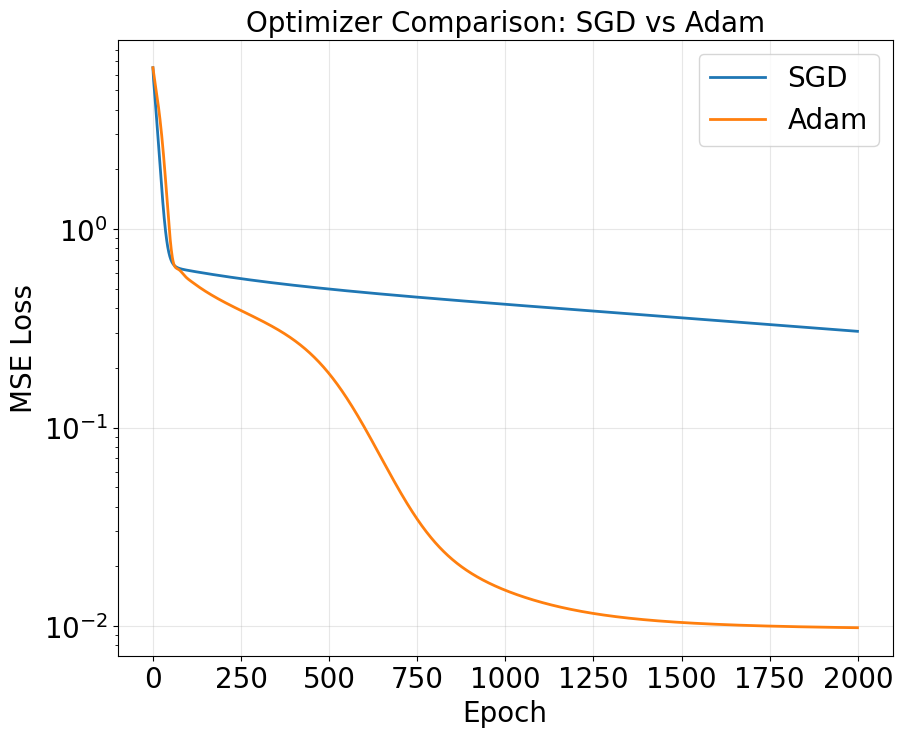

Final loss - SGD: 0.305340
Final loss - Adam: 0.009804


In [17]:
# Comparing SGD vs Adam optimizers
# Create two identical networks
net_sgd = PyTorchNetwork(input_dim=1, hidden_dim=20, output_dim=1)
net_adam = PyTorchNetwork(input_dim=1, hidden_dim=20, output_dim=1)

# Initialize with same weights for fair comparison
with torch.no_grad():
    # Copy weights from first network to the second
    net_adam.load_state_dict(net_sgd.state_dict())

# Define optimizers
optimizer_sgd = optim.SGD(net_sgd.parameters(), lr=0.03)
optimizer_adam = optim.Adam(net_adam.parameters(), lr=0.01)

# Training loop for comparison
n_epochs_comparison = 2000
losses = {'SGD': [], 'Adam': []}

for epoch in range(n_epochs_comparison):
    for name, net, opt in [('SGD', net_sgd, optimizer_sgd), 
                           ('Adam', net_adam, optimizer_adam)]:
        opt.zero_grad()
        y_pred = net(X_train_torch)
        loss = criterion(y_pred, y_train_torch)
        loss.backward()
        opt.step()
        losses[name].append(loss.item())

# Plot comparison
plt.figure(figsize=(10, 8))
plt.plot(losses['SGD'], linewidth=2, color=colors[0], label='SGD')
plt.plot(losses['Adam'], linewidth=2, color=colors[1], label='Adam')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Optimizer Comparison: SGD vs Adam')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print final losses
print(f"Final loss - SGD: {losses['SGD'][-1]:.6f}")
print(f"Final loss - Adam: {losses['Adam'][-1]:.6f}")

### Understanding the Optimizer Comparison

The comparison demonstrates Adam's advantages over basic SGD. Adam converges faster and achieves a lower final loss, illustrating the benefits of adaptive learning rates and momentum. While SGD steadily decreases the loss with a fixed learning rate for all parameters, Adam adjusts its step sizes based on the gradient history of each parameter.

This adaptive behavior is particularly beneficial for neural networks where different parameters may have vastly different gradient magnitudes. Parameters with consistently large gradients get smaller effective learning rates to prevent overshooting, while parameters with small gradients get boosted to ensure they continue learning.



### GPU Acceleration in PyTorch

While our NumPy implementation is limited to CPU computation, PyTorch can leverage GPUs for massive speedups. Although GPU access requires specialized hardware, understanding how to write GPU-compatible code is essential for scaling to larger models:

In [18]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device available: {device}")

# How to move models and data to GPU (if available)
# model = model.to(device)
# X_train_gpu = X_train_torch.to(device)
# y_train_gpu = y_train_torch.to(device)

# The training loop remains identical - PyTorch handles GPU operations automatically
# for epoch in range(n_epochs):
#     optimizer.zero_grad()
#     y_pred = model(X_train_gpu)  # Computation happens on GPU
#     loss = criterion(y_pred, y_train_gpu)
#     loss.backward()  # Gradients computed on GPU
#     optimizer.step()

# To move results back to CPU for visualization
# y_pred_cpu = y_pred.cpu().detach().numpy()

print("\nNote: GPU acceleration is particularly beneficial for:")
print("- Large matrix multiplications")
print("- Deep networks with many layers")
print("- Large batch sizes")
print("- Convolutional operations (for image processing)")

Device available: cpu

Note: GPU acceleration is particularly beneficial for:
- Large matrix multiplications
- Deep networks with many layers
- Large batch sizes
- Convolutional operations (for image processing)


The key insight is that PyTorch abstracts away the complexity of GPU programming. Once tensors and models are moved to the GPU with `.to(device)`, all operations—forward passes, backward passes, and parameter updates—automatically execute on the GPU. The same mathematical operations we implemented manually would run orders of magnitude faster on GPU hardware, especially for large matrices where parallelization provides the greatest benefit.

## Summary

This tutorial has taken us on a journey from manually implementing backpropagation to leveraging PyTorch's automatic differentiation capabilities. Through this progression, we've gained deep insights into how modern deep learning frameworks operate under the hood.

1. **Backpropagation Demystified**: By implementing forward and backward passes manually, we saw that backpropagation is simply a systematic application of the chain rule. Each layer caches values during the forward pass and uses them to compute gradients during the backward pass.

2. **Computational Graphs**: Both our manual implementation and PyTorch build computational graphs that track operations and dependencies. This graph structure enables efficient gradient computation by avoiding redundant calculations.

3. **Automatic Differentiation**: PyTorch automates what we coded manually—tracking operations, building graphs, and computing gradients. The `requires_grad=True` flag creates tensors that maintain both values and gradient computation machinery.

4. **Optimization Algorithms**: While basic SGD updates parameters directly with scaled gradients, advanced optimizers like Adam use gradient history to adapt learning rates for each parameter, often leading to faster convergence.

5. **Framework Benefits**: PyTorch provides not just automatic differentiation but also optimized operations, memory management, device abstraction, and a rich ecosystem of pre-built components—all while maintaining the mathematical rigor we implemented manually.

The transition from our NumPy implementation to PyTorch illustrates a broader principle in scientific computing: understanding the fundamentals enables us to effectively use sophisticated tools. While we'll rarely implement backpropagation from scratch in practice, this understanding helps us debug issues, make informed architectural choices, and push the boundaries of what's possible with neural networks.

As you continue exploring neural networks for astronomical applications, remember that PyTorch and similar frameworks are tools that implement the same mathematical principles we've studied. The power of these frameworks lies not in hiding complexity, but in automating the mechanical aspects of gradient computation, freeing us to focus on model design and scientific discovery.
```